Step 1: Install Necessary Libraries


In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow yfinance


Step 2: Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Step 3: Data Collection


In [ ]:
# Define the stock ticker and the date range
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-01-01')

# Display the first few rows of data
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02 00:00:00+00:00,24.373959,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06 00:00:00+00:00,23.689535,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07 00:00:00+00:00,24.021711,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08 00:00:00+00:00,24.944679,27.972500,28.037500,27.174999,27.307501,237458000


Step 4: Data Preprocessing


In [ ]:
# Extract the 'Close' column
close_prices = data['Close'].values
close_prices = close_prices.reshape(-1, 1)

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Define the sequence length (e.g., 60 days)
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X to be compatible with LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


Step 5: Build the LSTM Model


In [ ]:
# Initialize the model
model = Sequential()

# Add the first LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

# Add a second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Add a third LSTM layer with Dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Step 6: Train the Model


In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0316 - val_loss: 0.0034
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - 

Step 7: Make Predictions


In [ ]:
# Predict on test data
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual prices
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


Step 8: Visualize the Results


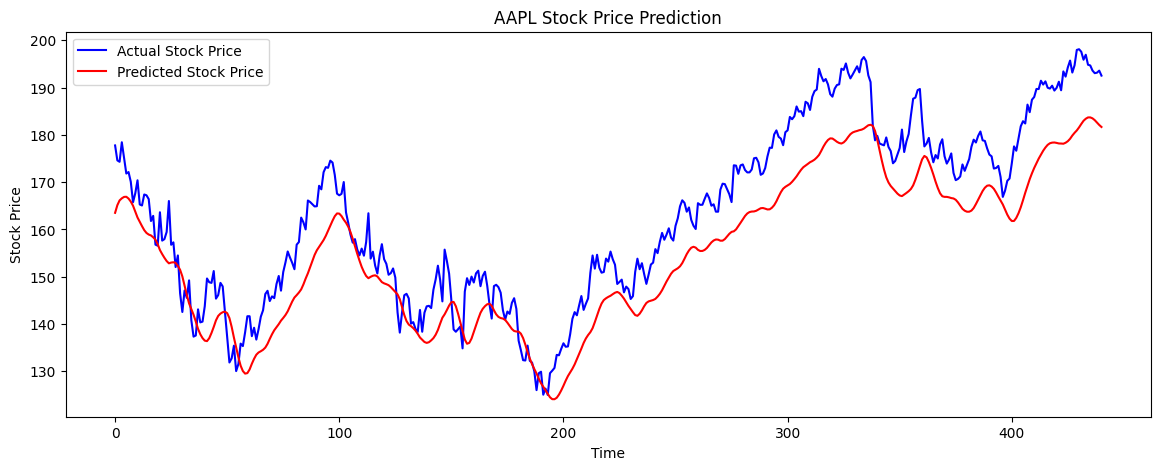

In [ ]:
# Plot the real and predicted prices
plt.figure(figsize=(14,5))
plt.plot(real_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Step 9: Evaluate the Model


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 89.8752277782653
Root Mean Squared Error: 9.480254626235801
